# Creative Machine Learning Experiments on the Metatone Data

In this notebook, I'll work on some ML experiments with the Metatone performance data. The goal is to create models of these performances that are more realistic than the first order models used in earlier experiments.

In [1]:
from __future__ import print_function
import os
import time
import pandas as pd
import numpy as np
import tensorflow as tf
import time
import os
import datetime
import pickle
from sklearn import datasets, metrics, cross_validation
from urllib import urlretrieve
import matplotlib.pyplot as plt
import random

URL = "https://github.com/anucc/metatone-analysis/raw/master/metadata/"
PICKLE_FILE = "metatone_performances_dataframe.pickle"

if not os.path.exists(PICKLE_FILE):
    urlretrieve(URL + PICKLE_FILE, PICKLE_FILE)

with open(PICKLE_FILE, 'rb') as f:
        metatone_dataset = pickle.load(f)
        
## Int values for Gesture codes.
NUMBER_GESTURES = 9
GESTURE_CODES = {
    'N': 0,
    'FT': 1,
    'ST': 2,
    'FS': 3,
    'FSA': 4,
    'VSS': 5,
    'BS': 6,
    'SS': 7,
    'C': 8}

## Descriptive Statistics of the dataset

Number of records: 72
Min performers: 2 Max performers: 9
Total performer-records: 252


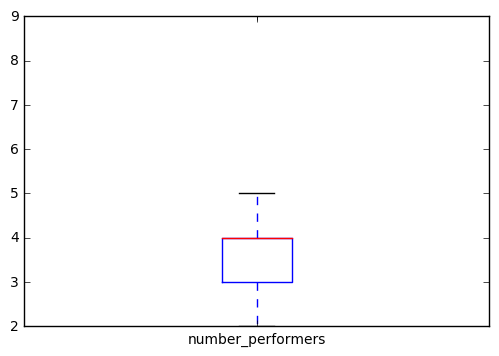

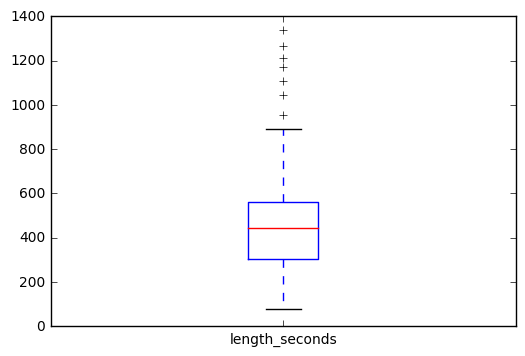

490.031380083
443.092919


In [2]:
improvisations = metatone_dataset[
    (metatone_dataset["performance_type"] == "improvisation") &
    (metatone_dataset["performance_context"] != "demonstration")]

#print(str(improvisations["performance_type"].unique()))
#print(str(improvisations["performance_context"].unique()))

print("Number of records: " + str(improvisations["number_performers"].count()))
print("Min performers: " + str(improvisations["number_performers"].min()) + " Max performers: "+ str(improvisations["number_performers"].max()))
print("Total performer-records: " + str(improvisations["number_performers"].sum()))


performers = improvisations["number_performers"].plot(kind="box")
plt.show(performers)


length_plot = improvisations['length_seconds'].plot(kind="box")
plt.show(length_plot)
print(improvisations['length_seconds'].mean())
print(improvisations['length_seconds'].median())

## Process Data

Isolate the gesture arrays and process them.

In [3]:
gesture_data = improvisations['gestures']
individual_improvisations = []
for perf in gesture_data.tolist():
    for one_perf in perf.T:
        individual_improvisations.append(one_perf)

print("Dataset contains " + str(len(individual_improvisations)) + " individual improvisations.")

vocabulary_size = len(GESTURE_CODES)

Dataset contains 252 individual improvisations.


## Segment and Prepare the Data

Segment the data into inputs and output list of length `num_steps`. Each record in the data is sliced into as many such lists as possible and the total size of the corpus is printed out for reference.

In [4]:
## Setup the epochs
def generate_epochs(num_epochs, num_steps, batch_size):
    ## Setup the inputs and label sets
    imp_xs = []
    imp_ys = []

    for imp in individual_improvisations:
        for i in range(len(imp)-num_steps-1):
            imp_x = imp[i:i+num_steps]
            imp_y = imp[i+1:i+num_steps+1]
            imp_xs.append(imp_x)
            imp_ys.append(imp_y)
    
    dataset = zip(imp_xs,imp_ys)
    print("Total Training Examples: " + str(len(imp_xs)))
    print("Total Training Labels: " + str(len(imp_ys)))
    epochs = []
    for j in range(num_epochs):
        # shutffle the big list
        np.random.shuffle(dataset)
        dataset_size = len(dataset)
        batches = []
        for i in range(dataset_size / batch_size):
            ## Setup the batches
            batch = dataset[i*batch_size:(i+1)*batch_size]
            bx,by = zip(*batch)
            batches.append((np.array(bx),np.array(by)))
        epochs.append(batches)
    return epochs

# Test 
#a = generate_epochs(2,10,20)
#e1 = a[0]
#e2 = a[1]
#print(len(e1))
#print(len(e2))
#print(e1[0][0].shape)

## Simple LSTM Model

Setup a simple 3-Layer LSTM Model with 64 nodes in each layer.

In [5]:
def reset_graph():
    if 'sess' in globals() and sess:
        sess.close()
    tf.reset_default_graph()

## Training Network

num_nodes = 64
num_classes = vocabulary_size
batch_size = 64
num_steps = 120
num_layers = 3
learning_rate = 1e-4
  
#graph = tf.Graph()
reset_graph()
graph = tf.get_default_graph()
with graph.as_default():
    x = tf.placeholder(tf.int32,[batch_size,num_steps], name='input_placeholder')
    y = tf.placeholder(tf.int32,[batch_size,num_steps], name='labels_placeholder')
    embeddings = tf.get_variable('embedding_matrix', [num_classes, num_nodes])
    rnn_inputs = tf.nn.embedding_lookup(embeddings,x)
    
    # Define the network
    cell = tf.nn.rnn_cell.LSTMCell(num_nodes,state_is_tuple=True)
    cell = tf.nn.rnn_cell.MultiRNNCell([cell] * num_layers, state_is_tuple=True)
    init_state = cell.zero_state(batch_size,tf.float32)
    rnn_outputs, final_state = tf.nn.dynamic_rnn(cell, rnn_inputs, initial_state=init_state)
    
    with tf.variable_scope('softmax'):
        W = tf.get_variable('W',[num_nodes,num_classes])
        b = tf.get_variable('b',[num_classes], initializer=tf.constant_initializer(0.0))
       
    rnn_outputs = tf.reshape(rnn_outputs,[-1,num_nodes])
    y_reshaped = tf.reshape(y,[-1])
    
    logits = tf.matmul(rnn_outputs, W) + b
    predictions = tf.nn.softmax(logits)
    
    total_loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits, y_reshaped))
    train_step = tf.train.AdamOptimizer(learning_rate).minimize(total_loss)
    saver = tf.train.Saver()

In [51]:
print("Shape of input tensor")
print(x)
print("Shape of output tensor")
print(y)
print(predictions)

Shape of input tensor
Tensor("input_placeholder:0", shape=(64, 50), dtype=int32)
Shape of output tensor
Tensor("labels_placeholder:0", shape=(64, 50), dtype=int32)
Tensor("Softmax:0", shape=(3200, 9), dtype=float32)


## Train the Model

In [8]:
num_epochs = 100
tf.set_random_seed(2345)

with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    training_losses = []
    print("Starting Training")
    for epoch in generate_epochs(num_epochs, num_steps, batch_size):
        ## Setup for each epoch
        training_loss = 0
        steps = 0
        training_state = None
        print("Starting an Epoch.")
        for batch_data, batch_labels in epoch:
            #print(batch_data.shape)
            #print(batch_labels.shape)
            ## Setup for each batch
            feed = {x:batch_data, y:batch_labels}
            if training_state is not None:
                feed[init_state] = training_state
            #print(str(feed))
            ## Evaluate the train step
            training_loss_current, training_state, _ = sess.run([total_loss,final_state,train_step],feed_dict=feed)
            steps += 1
            training_loss += training_loss_current
            if (steps % 500 == 0): 
                print("Trained batch: " + str(steps) + " of " + str(len(epoch)) + " loss was: " + str(training_loss_current))
        print("Trained an epoch.")
        training_losses.append(training_loss/steps)
    ## Save the results
    saver.save(sess,"single-trained-model.tfsave")
    #tf.train.Saver()

Starting Training
Total Training Examples: 130427
Total Training Labels: 130427


KeyboardInterrupt: 

Epoch vs Training Losses


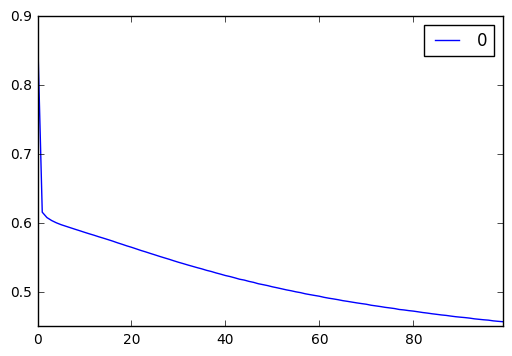

In [61]:
## Plot Training Results:
a = pd.DataFrame(training_losses)
print("Epoch vs Training Losses")
plt.show(a.plot())

In [9]:
## Evaluating Network

batch_size = 1
num_steps = 1

#graph = tf.Graph()
reset_graph()
graph = tf.get_default_graph()
with graph.as_default():
    x = tf.placeholder(tf.int32,[batch_size,num_steps], name='input_placeholder')
    y = tf.placeholder(tf.int32,[batch_size,num_steps], name='labels_placeholder')
    embeddings = tf.get_variable('embedding_matrix', [num_classes, num_nodes])
    rnn_inputs = tf.nn.embedding_lookup(embeddings,x)
    
    # Define the network
    cell = tf.nn.rnn_cell.LSTMCell(num_nodes,state_is_tuple=True)
    cell = tf.nn.rnn_cell.MultiRNNCell([cell] * num_layers, state_is_tuple=True)
    init_state = cell.zero_state(batch_size,tf.float32)
    rnn_outputs, final_state = tf.nn.dynamic_rnn(cell, rnn_inputs, initial_state=init_state)
    
    with tf.variable_scope('softmax'):
        W = tf.get_variable('W',[num_nodes,num_classes])
        b = tf.get_variable('b',[num_classes], initializer=tf.constant_initializer(0.0))
       
    rnn_outputs = tf.reshape(rnn_outputs,[-1,num_nodes])
    y_reshaped = tf.reshape(y,[-1])
    
    logits = tf.matmul(rnn_outputs, W) + b
    predictions = tf.nn.softmax(logits)
    
    total_loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits, y_reshaped))
    train_step = tf.train.AdamOptimizer(learning_rate).minimize(total_loss)
    saver = tf.train.Saver()
    
def plot_gesture_only_score(plot_title, gestures):
    """
    Plots a gesture score of gestures only - no new ideas!
    """
    idx = gestures.index
    plt.style.use('ggplot')
    ax = plt.figure(figsize=(14, 4), frameon=False, tight_layout=True).add_subplot(111)
    ax.yaxis.grid()
    plt.ylim(-0.5, 8.5)
    plt.yticks(np.arange(9), ['n', 'ft', 'st', 'fs', 'fsa', 'vss', 'bs', 'ss', 'c'])
    for n in gestures.columns:
        plt.plot(gestures.index, gestures[n], '-', label=n)
    #plt.savefig(plot_title.replace(":", "_") + '.pdf', dpi=150, format="pdf")
    #plt.close()
    plt.show()

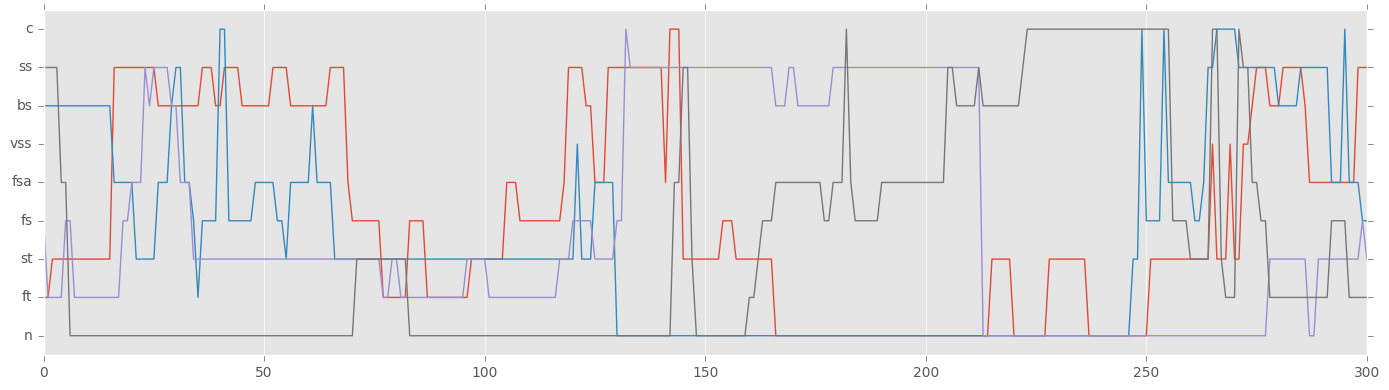

In [17]:
num_gen_steps = 300
num_performers = 4
generated_performance = pd.DataFrame()

for j in range(num_performers):
    with tf.Session() as sess:
        # possibly restore all variables
        sess.run(tf.initialize_all_variables())
        saver.restore(sess, "./single-trained-model.tfsave")
        
        # start generating output
        state = None
        current_step = random.choice(range(vocabulary_size))
        output_perf = [current_step]
        
        for i in range(num_gen_steps):
            if state is not None:
                feed_dict = {x: [[current_step]], init_state: state}
            else:
                feed_dict = {x: [[current_step]]}
            preds,state = sess.run([predictions,final_state],feed_dict=feed_dict)
            current_step = np.random.choice(vocabulary_size,1,p=np.squeeze(preds))[0] # choose the output step
            output_perf.append(current_step)
    output_perf = pd.DataFrame({j:output_perf})
    generated_performance[j] = output_perf[j]

#generated_performance.to_csv("100epoch-120step-performances")   
#plt.show(generated_performance.plot())
plot_gesture_only_score("Independent Performer Model", generated_performance)

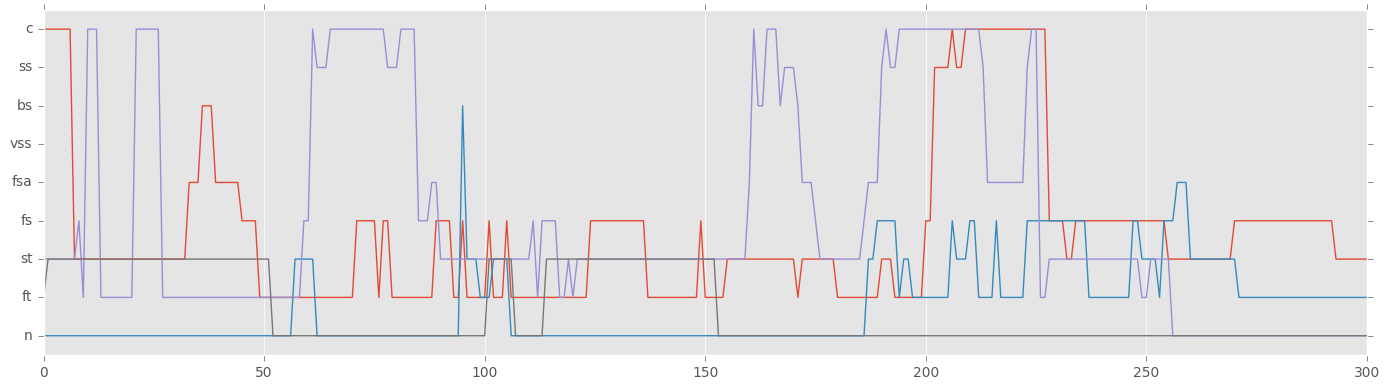